# 推理与部署

本章是在狗和牛角包的案例的基础上进行改进的，将二分类问题升级为多分类问题，我们分别做了十分类和四分类的训练，但是结果表明四分类的效果是比较好的。使用MindSpore中的`mobilenet_v2`网络微调的方法来开发一个AI应用（10animals分类），并将训练好的网络模型部署到Android手机上，执行推理和部署功能。

## 数据准备与加载

### 下载数据集

首先需要下载本案例所用到的10animals分类数据集，在kaggle官网下载该数据集，该数据集有狗、毛、羊、马等10个类别，做的四分类的小数据集中包含四个分类，分别是狗、羊、马、大象等四个分类，每个类有大约800张训练图像、200张验证图像和4张推理图像。我们将下载的数据集放到与模型文件同目录下的datasets文件夹中，数据集的结构如下所示：
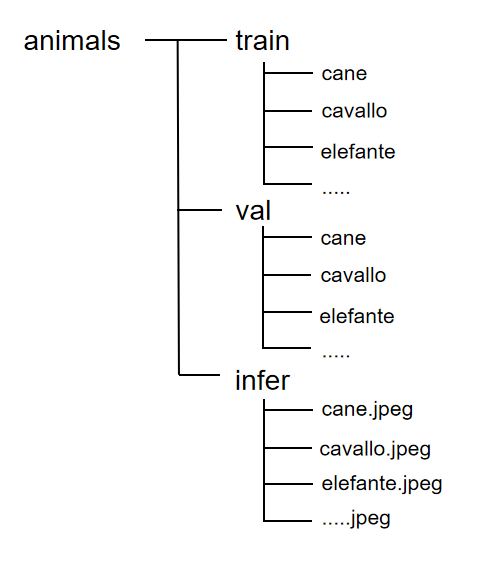

In [1]:
path = "./datasets"

### 加载数据集

定义 `create_dataset`函数加载10animals数据集，对数据集进行图像增强操作并设置数据集batch_size大小。

In [3]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

#加载数据集
def create_dataset(path, batch_size=10, train=True, image_size=224):
    #dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={"cane": 0, "cavallo": 1, "elefante": 2, "farfalla": 3, "gallina": 4, "gatto": 5, "mucca": 6, "pecora": 7, "ragno": 8, "scoiattolo": 9})
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={"cane": 0, "cavallo": 1, "elefante": 2, "pecora": 3})
    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            vision.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        trans = [
            vision.Decode(),
            vision.Resize(256),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset



加载训练数据集和验证数据集用于后续的模型训练和验证。

In [4]:
# 加载训练数据集
train_path = "./datasets/10animals/train"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./datasets/10animals/val"
dataset_val = create_dataset(val_path, train=False)

## 模型训练

本案例使用预训练模型在10animals的分类数据集上对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

### 下载预训练模型

下载案例所需的预训练模型，我们使用的预训练模型是原案例的升级版mobilenet_v2_1.4_224.ckpt，模型的宽度系数𝛼=1.0，输入图像大小为(224, 224), 将下载的预训练模型保存在当前目录下。使用MindSpore Vision中的`DownLoad`下载预训练模型文件到当前目录下，示例代码如下所示：

In [5]:
from mindvision.dataset import DownLoad

models_url = "https://download.mindspore.cn/vision/classification/mobilenet_v2_1.4_224.ckpt"

dl = DownLoad()
# 下载预训练模型文件
dl.download_url(models_url)

### MobileNet V2模型微调

本章使用MobileNet V2的预训练模型进行微调，通过删除MobileNet V2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用10animals数据集对模型进行重新训练以更新模型参数，并设置分类的类型数为4

In [6]:
import mindspore.nn as nn
import mindspore as ms

from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为4，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=4, resize=224)

# 模型参数存入到param_dict
param_dict = ms.load_checkpoint("./mobilenet_v2_1.4_224.ckpt")

# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
ms.load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=4)

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = ms.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)



[WARNING] ME(7704:11332,MainProcess):2022-07-03-16:46:07.736.665 [mindspore\train\serialization.py:645] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(7704:11332,MainProcess):2022-07-03-16:46:07.736.665 [mindspore\train\serialization.py:650] head.classifier.weight is not loaded.
[WARNING] ME(7704:11332,MainProcess):2022-07-03-16:46:07.752.286 [mindspore\train\serialization.py:650] head.classifier.bias is not loaded.


Delete parameter from checkpoint:  head.classifier.weight
Delete parameter from checkpoint:  head.classifier.bias
Delete parameter from checkpoint:  moments.head.classifier.weight
Delete parameter from checkpoint:  moments.head.classifier.bias


## <font color='red'> 存在的问题</font>

由于使用新的预训练模型导致模型参数出现了变化，而在参数封装在`mobilenet_v2`函数中，所以我们在Pycharm中进行断点调试，修改了部分源码

### 修改部分如下：

`from mindvision.classification.models import mobilenet_v2` 中

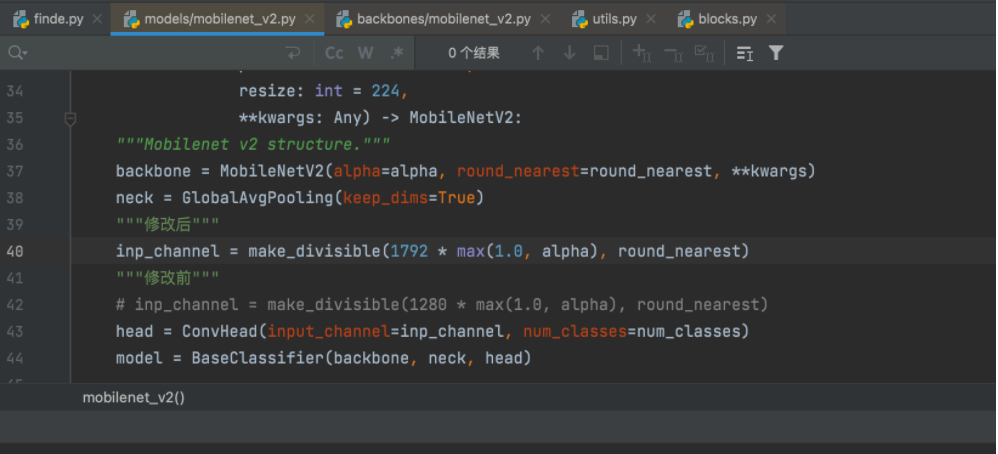

`from mindvision.classification.models.backbones import MobileNet_v2`中
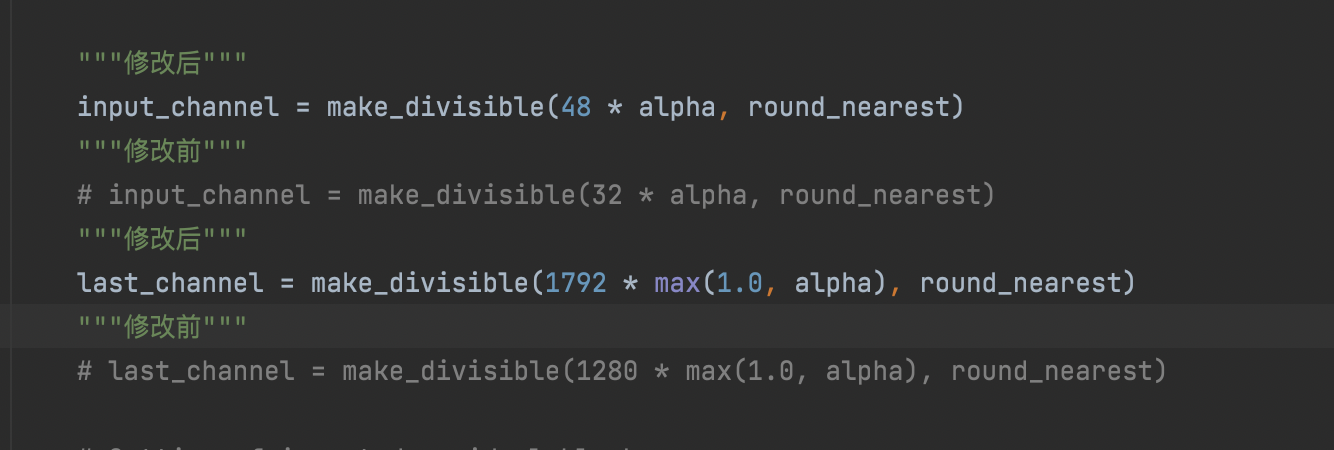

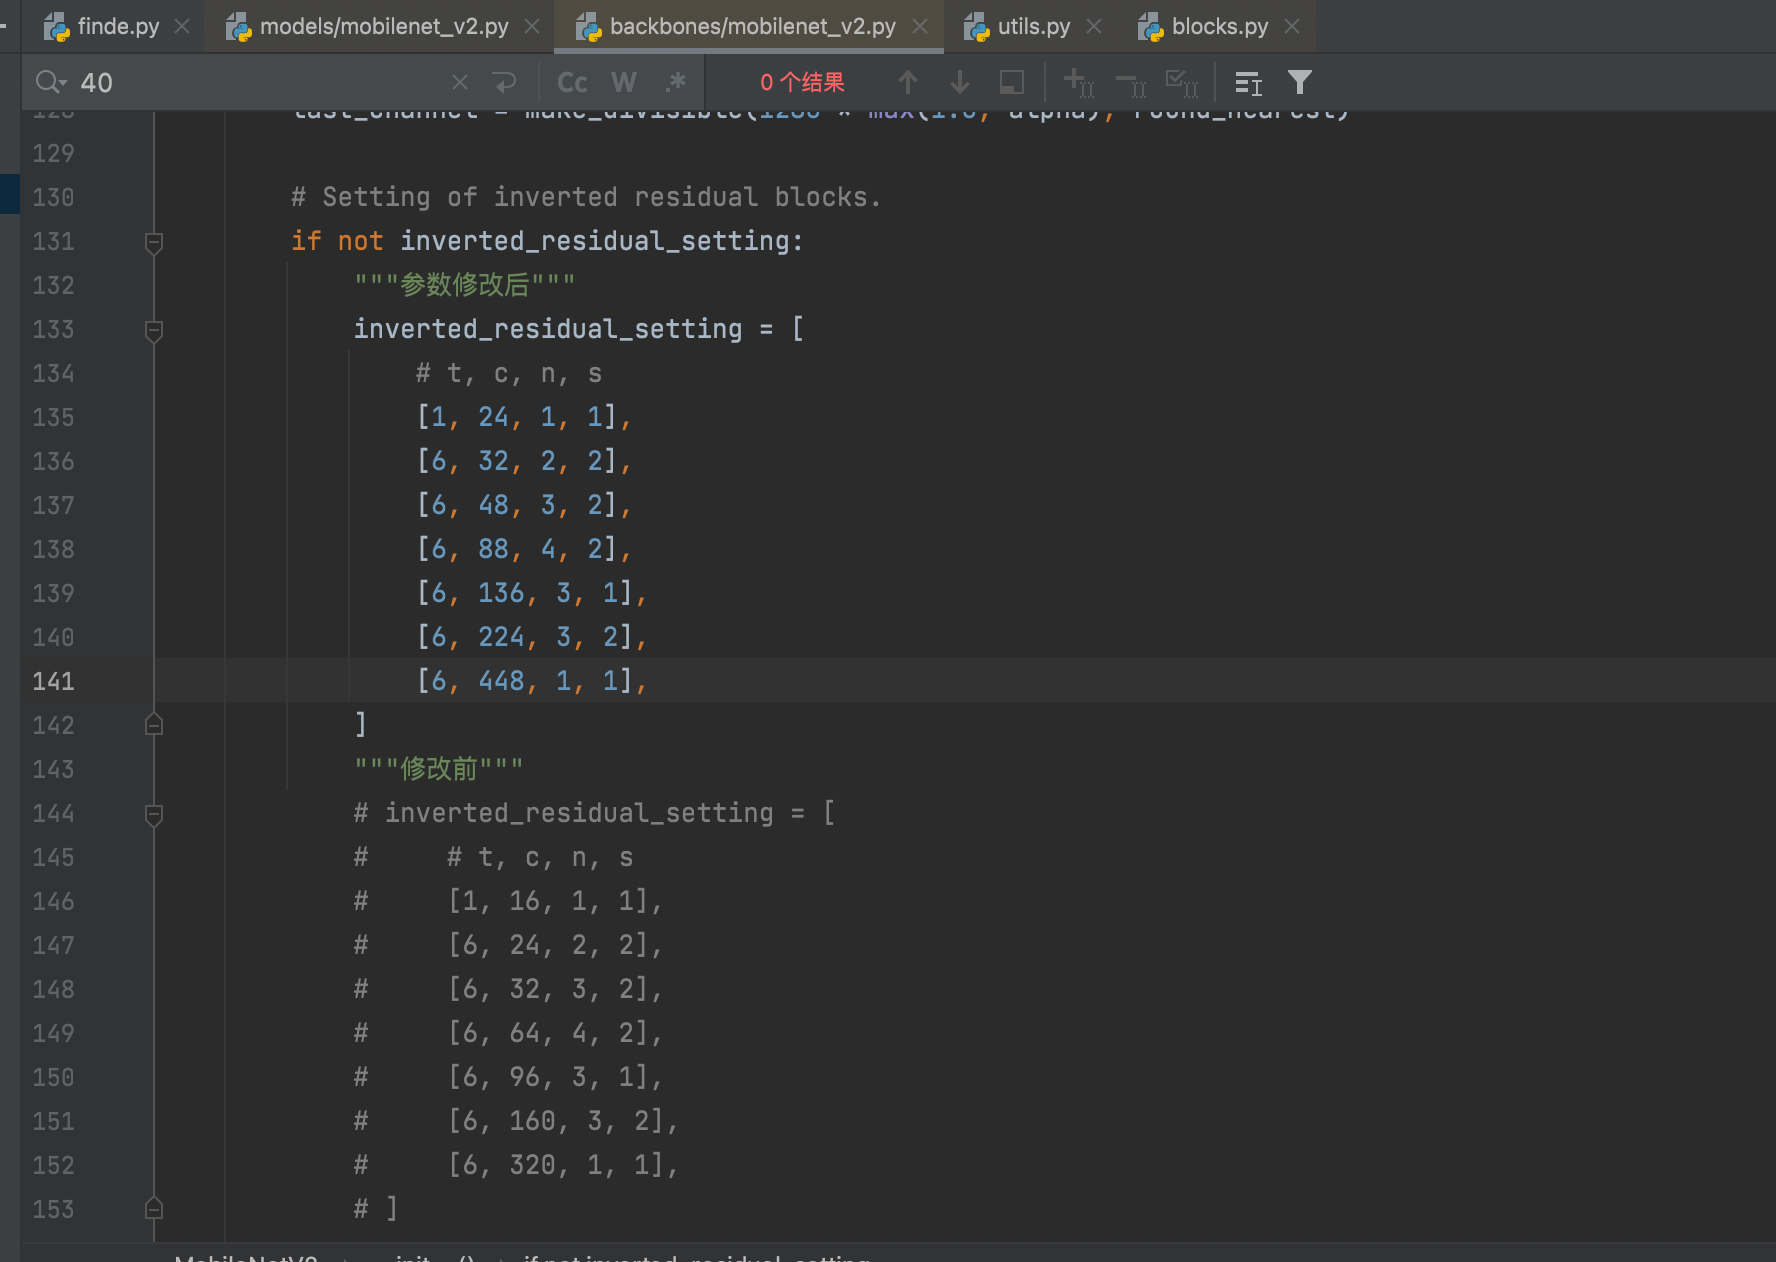

### 模型训练与评估

训练并评估网络，使用MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的CKPT文件`best.ckpt`在当前目录下。

In [7]:
from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor

num_epochs = 10

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])

--------------------
Epoch: [  1 /  10], Train Loss: [0.530], Accuracy:  0.985
epoch time: 869734.254 ms, per step time: 1509.955 ms
--------------------
Epoch: [  2 /  10], Train Loss: [0.544], Accuracy:  0.992
epoch time: 803749.395 ms, per step time: 1395.398 ms
--------------------
Epoch: [  3 /  10], Train Loss: [0.466], Accuracy:  0.996
epoch time: 869047.254 ms, per step time: 1508.763 ms
--------------------
Epoch: [  4 /  10], Train Loss: [0.546], Accuracy:  1.000
epoch time: 923866.477 ms, per step time: 1603.935 ms
--------------------
Epoch: [  5 /  10], Train Loss: [0.473], Accuracy:  1.000
epoch time: 920344.855 ms, per step time: 1597.821 ms
--------------------
Epoch: [  6 /  10], Train Loss: [0.457], Accuracy:  1.000
epoch time: 925649.272 ms, per step time: 1607.030 ms
--------------------
Epoch: [  7 /  10], Train Loss: [0.671], Accuracy:  1.000
epoch time: 913562.356 ms, per step time: 1586.046 ms
--------------------
Epoch: [  8 /  10], Train Loss: [0.579], Accurac

### 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化。

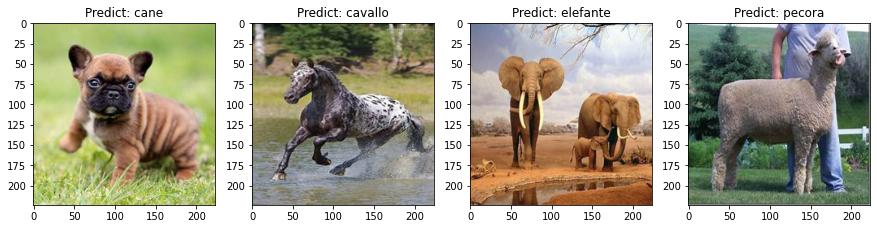

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from mindspore import Tensor

def visualize_model(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = mobilenet_v2(num_classes=4, resize=224)
    param_dict = ms.load_checkpoint("./best.ckpt")
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)

    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "cane", 1: "cavallo", 2: "elefante", 3: "pecora"}
    plt.title(f"Predict: {class_name[result]}")
    return result

image1 = "./datasets/10animals/infer/cane.jpeg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 4, 1)
visualize_model(image1)

image2 = "./datasets/10animals/infer/cavallo.jpeg"
plt.subplot(1, 4, 2)
visualize_model(image2)

image3 = "./datasets/10animals/infer/elefante.jpeg"
plt.subplot(1, 4, 3)
visualize_model(image3)

image4 = "./datasets/10animals/infer/pecora.jpeg"
plt.subplot(1, 4, 4)
visualize_model(image4)

plt.show()

### 模型导出

在模型训练完后，训练完成后的网络模型（即CKPT文件）转换为MindIR格式，用于后续手机侧的推理。通过`export`接口会在当前目录下会生成`mobilenet_v2_1.4_224.mindir`文件。

In [9]:
from mindspore import export, Tensor

# 定义并加载网络参数
net = mobilenet_v2(num_classes=10, resize=224)
param_dict = ms.load_checkpoint("best.ckpt")
ms.load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(net, Tensor(input_np), file_name="mobilenet_v2_1.4_224", file_format="MINDIR")

### 手机侧推理与部署

为实现模型文件在手机侧的推理功能，步骤如下：

- 转换文件格式：将MindIR文件格式，转换成Android手机上MindSpore Lite可识别文件；
- 应用部署：在手机侧部署应用APK，即下载一个MindSpore Vision套件Android APK；
- 应用体验：最后将ms模型文件导入到手机侧后，体验10animals的识别功能。

### 转换文件格式

使用端侧应用的转换工具MindSpore Lite Converter，将训练过程当中生成的mobilenet_v2_1.4_224.mindir文件，转换为MindSpore Lite端侧推理框架可识别的文件格式mobilenet_v2_1.4_224.ms文件。

转换成功后打印`CONVERT RESULT SUCCESS:0`，且在当前目录下生成`mobilenet_v2_1.4_224.ms`文件。
最后将编辑好的.json文件以及生成的.ms文件下载到手机的同一个目录下，打开手机的应用软件就可以实现拍照来识图分类了
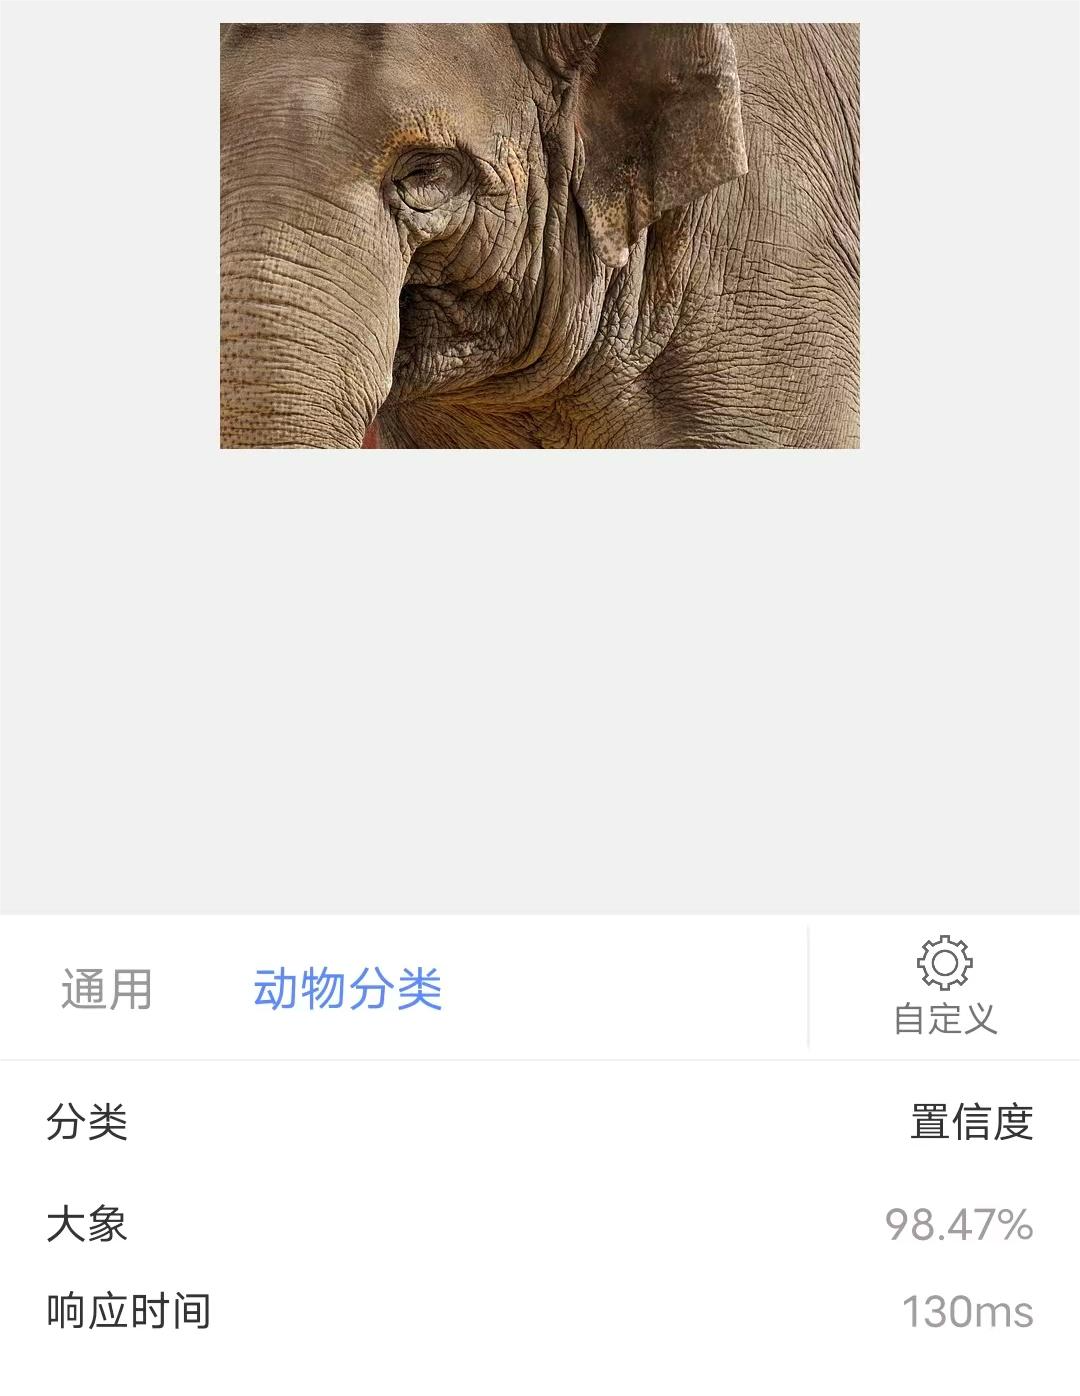

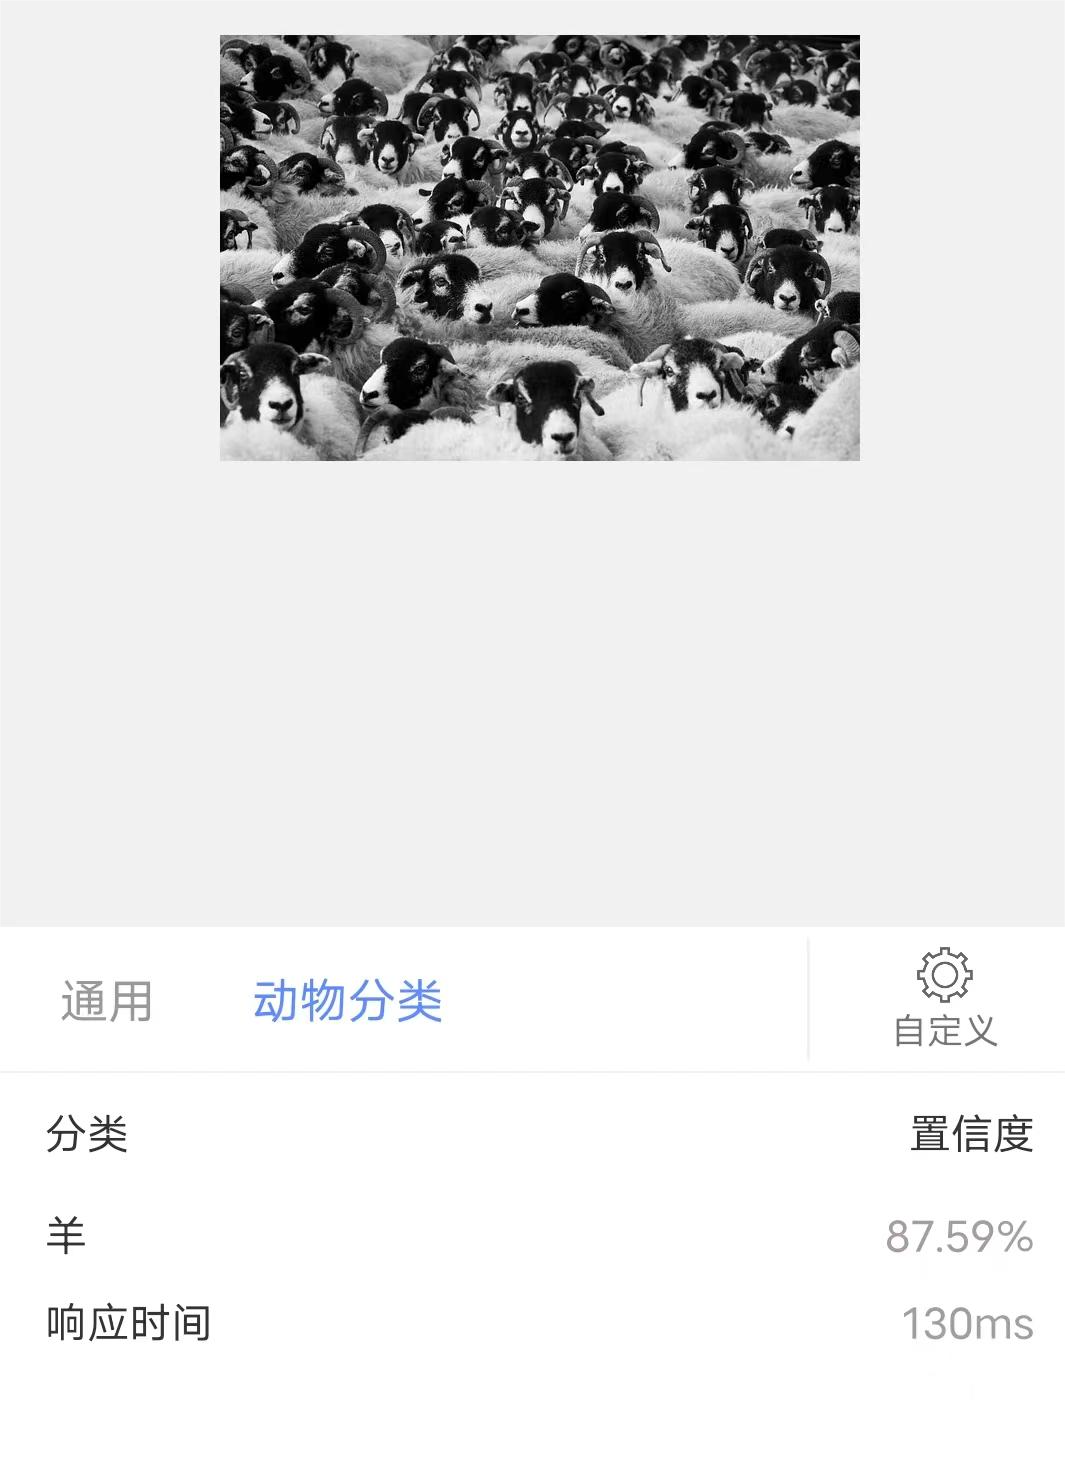